# 10: Which models work and which don't?

#### Let's look at the top 5 models that fit the data really well and the worst 5 models that fit the data poorly.

Building on the previous notebook, where we learned how to plot rupture and deformation models and calculate RMS errors to quantify model fit, we now take the next step: identifying and visualizing the best-fitting and worst-fitting models. This approach helps us understand which models most closely match the paleo data and which ones deviate the most, providing valuable insight into model performance and data constraints.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob
import os

The `os` module in Python provides a way to interact with the operating system. It allows you to perform tasks such as navigating the file system, creating or deleting files and directories, and accessing environment variables. In this notebook, we use `os` to list folders, join file paths, and check if files or directories exist. This makes it easier to work with files and directories in a platform-independent way.

In this notebook, because there will be lots of repetitive calculations, we will use functions again. We've encountered functions before—they help us organize our code, avoid repetition, and make our workflow more efficient and readable. Functions allow us to encapsulate specific tasks, making it easier to reuse code and debug or update our analysis as needed.


In [8]:
def compute_rms(lat, deformation, paleo_point_lat, paleo_point_deformation, mask_nan=True):
    """
    Compute the root mean square (RMS) error between model deformation and paleo data.

    Parameters:
        lat (array-like): Latitudes of the model deformation.
        deformation (array-like): Model deformation values.
        paleo_point_lat (array-like): Latitudes of paleo data points.
        paleo_point_deformation (array-like): Paleo deformation values.
        mask_nan (bool): If True, ignore NaNs in paleo data.

    Returns:
        float: RMS error.
    """
    # Interpolate the deformation at the paleo point latitude
    interpolant = interp1d(lat, deformation, bounds_error=False, fill_value="extrapolate")
    interpolated_deformation = interpolant(paleo_point_lat)

    # Optionally mask NaN values in paleo data
    if mask_nan:
        mask = ~np.isnan(paleo_point_deformation)
        diff = interpolated_deformation[mask] - paleo_point_deformation[mask]
    else:
        diff = interpolated_deformation - paleo_point_deformation

    # Calculate RMS
    rms = np.sqrt(np.mean(diff ** 2))
    return rms

In [9]:
# Now let's do things a little differently:
# We'll make a list of all the rupture files, and a separate list of all the deformation files,
# then loop over them to get the RMS.

# Get sorted list of all rupture files
all_ruptures = np.sort(glob('/Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/ruptures/gamma/*.rupt'))

# Root directory containing all deformation model subfolders
deformation_root = '/Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/gamma_deformation/'
all_deformation_models = []

# Loop through each subfolder in the deformation root directory
for subfolder in sorted(os.listdir(deformation_root)):
    subfolder_path = os.path.join(deformation_root, subfolder)
    statics_file = os.path.join(subfolder_path, 'statics.neu')
    # Only add if subfolder is a directory and statics.neu file exists
    if os.path.isdir(subfolder_path) and os.path.isfile(statics_file):
        all_deformation_models.append(os.path.abspath(statics_file))

In the previous cell, we used the `os` module to efficiently navigate the file system and identify valid deformation model files. Specifically, we:

- Used `os.listdir(deformation_root)` to list all subfolders within the main deformation directory.
- Combined folder names with the root path using `os.path.join()` to create full paths to each subfolder and the expected `statics.neu` file.
- Checked if each subfolder is a directory with `os.path.isdir()` and verified the existence of the `statics.neu` file using `os.path.isfile()`.
- Only added the absolute path of the `statics.neu` file to our list if both conditions were met.

This approach ensured that we only processed valid deformation model files, making our workflow robust and platform-independent.

In [10]:
#spot checks to see that this worked
print(all_ruptures[100],all_deformation_models[100])

/Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/ruptures/gamma/cascadia1700_gamma.000100.rupt /Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/gamma_deformation/cascadia1700_gamma.000100/statics.neu


In [11]:
# Load paleo data from file
paleo_data = np.genfromtxt('/Users/dmelgarm/Cascadia1700/paleo/paleo_data.txt')

# Extract paleo latitudes and deformations
paleo_lat = paleo_data[:, 0]
paleo_deformation = paleo_data[:, 2]
paleo_uncertainty = paleo_data[:, 3]

# Initialize array to store RMS values for each deformation model
rms_values = np.zeros(len(all_deformation_models))

# Loop over all deformation models and compute RMS with respect to paleo data
for i, deformation_file in enumerate(all_deformation_models):
    deformation_data = np.genfromtxt(deformation_file)
    model_lat = deformation_data[:, 2]
    model_deformation = deformation_data[:, 5]
    rms_values[i] = compute_rms(model_lat, model_deformation, paleo_lat, paleo_deformation)

# find best 5 fitting models print names and RMS values to screen
best_fit_indices = np.argsort(rms_values)[:5]
print ("Best fitting models (lowest RMS values):")
for i in best_fit_indices:
    print(f"... model: {all_deformation_models[i]}, RMS: {rms_values[i]}")

# Do the same for 5 worst models
print("\nWorst fitting models (highest RMS values):")
worst_fit_indices = np.argsort(rms_values)[-5:]
for i in worst_fit_indices:
    print(f"... model: {all_deformation_models[i]}, RMS: {rms_values[i]}")

Best fitting models (lowest RMS values):
... model: /Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/gamma_deformation/cascadia1700_gamma.000314/statics.neu, RMS: 0.3449135207024663
... model: /Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/gamma_deformation/cascadia1700_gamma.000339/statics.neu, RMS: 0.35096383539957143
... model: /Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/gamma_deformation/cascadia1700_gamma.000563/statics.neu, RMS: 0.35548137430292576
... model: /Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/gamma_deformation/cascadia1700_gamma.000722/statics.neu, RMS: 0.355949630598244
... model: /Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/gamma_deformation/cascadia1700_gamma.000554/statics.neu, RMS: 0.35747408434813027

Worst fitting models (highest RMS values):
... model: /Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/output/gamma_deformation/cascadia1700_gamma.000849/statics.neu, RMS: 1.7243549414330395
... model: /Users/dmelgarm/FakeQuakes/Cascadia1700_M9s/

Neat, to find the 5 best-fitting models we:

- Loaded the paleo data (latitude and deformation) from a file.
- Iterated through all available deformation model files.
- For each model, loaded its deformation data and computed the root mean square (RMS) error between the model predictions and the paleo data using the `compute_rms` function.
- Stored the RMS error for each model in an array.
- Sorted the models by their RMS error and selected the 5 models with the lowest RMS values, which correspond to the best fit to the paleo data.
- Printed the filenames and RMS values of these best-fitting models for further analysis and visualization.

Let's visualize them now

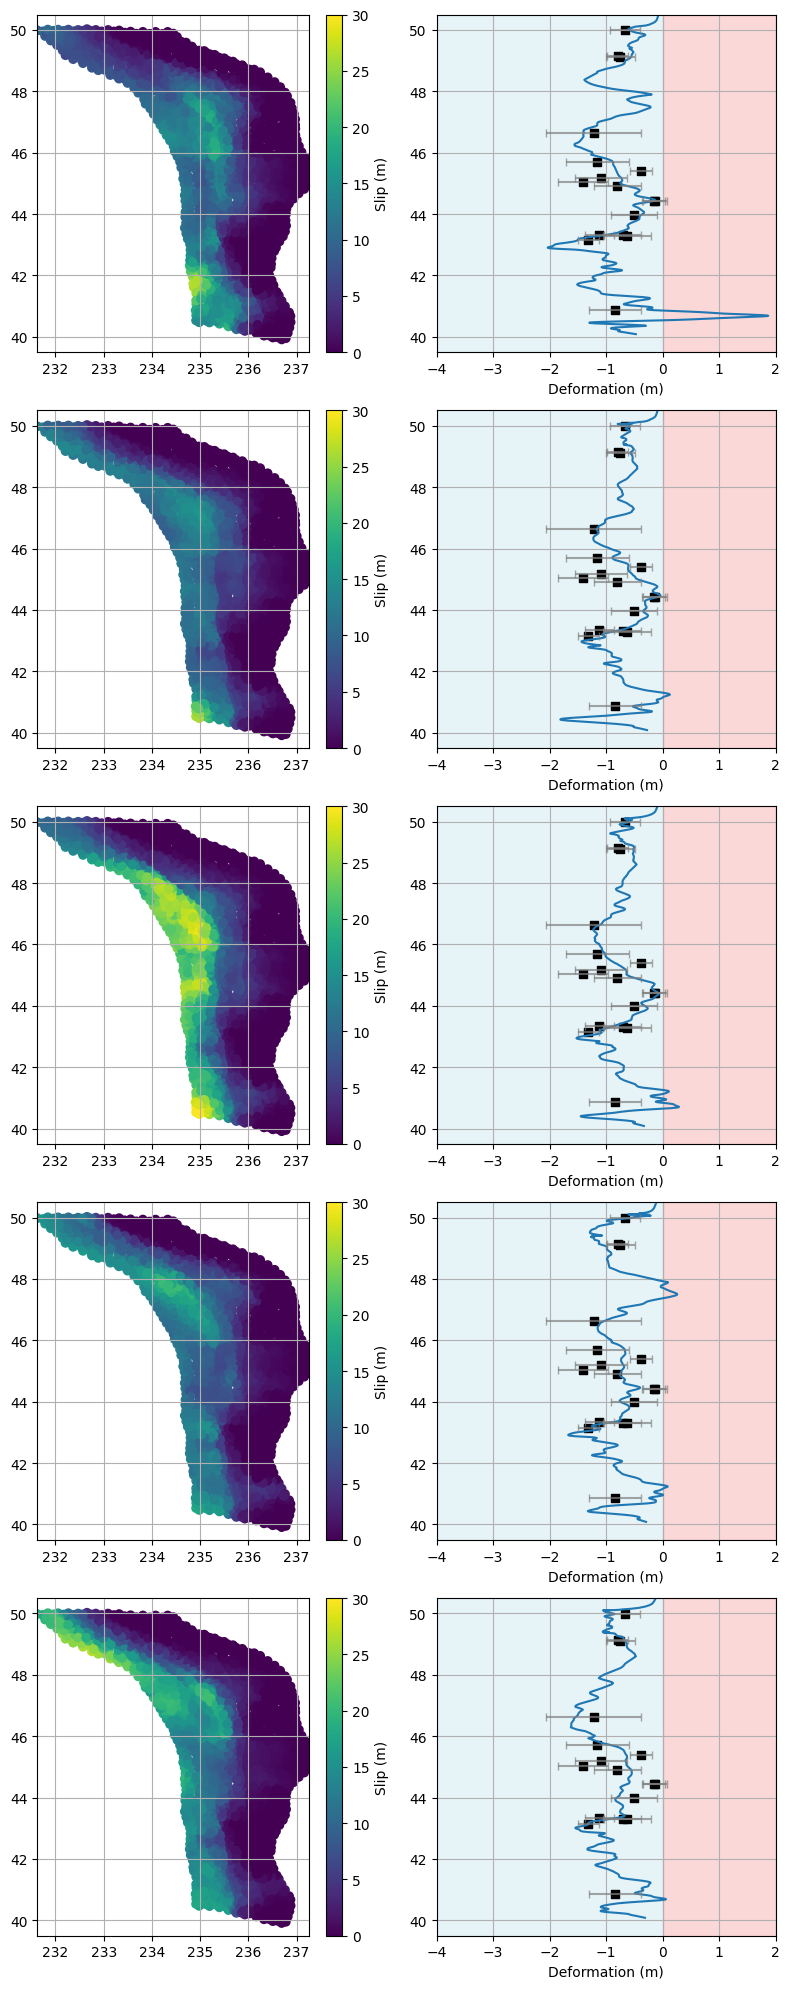

In [ ]:
# Plot slip and deformation for each of the best fitting models (2 panels per model, 10 panels total)
fig, axes = plt.subplots(5, 2, figsize=(8, 20))
axes = axes.flatten()

lat_lims = (39.5,50.5)
deformation_lims = (-4,2)

for idx, model_idx in enumerate(best_fit_indices):
    # Load deformation data
    deformation_data = np.genfromtxt(all_deformation_models[model_idx])
    # Extract lat and deformation, then sort by lat
    model_lat = deformation_data[:, 2]
    model_deformation = deformation_data[:, 5]
    sort_idx = np.argsort(model_lat)
    model_lat = model_lat[sort_idx]
    model_deformation = model_deformation[sort_idx]
    
    # Find corresponding rupture file (assumes matching order)
    rupture_file = all_ruptures[model_idx]
    rupture_data = np.genfromtxt(rupture_file)
    # Assuming slip is in column 3 and lat in column 2 (adjust if needed)
    rupture_lon = rupture_data[:, 1]
    rupture_lat = rupture_data[:, 2]
    rupture_slip = rupture_data[:, 9]
    
    # Plot slip
    ax1 = axes[2*idx]
    sc = ax1.scatter(rupture_lon, rupture_lat, c=rupture_slip, cmap='viridis', vmin=0, vmax=30)
    fig.colorbar(sc, ax=ax1, label='Slip (m)')
    ax1.set_xlim(rupture_lon.min(), rupture_lon.max())
    ax1.set_ylim(lat_lims)
    ax1.grid(which='both')

    # Plot deformation
    ax2 = axes[2*idx+1]
    ax2.plot(model_deformation, model_lat)
    ax2.scatter(paleo_deformation,paleo_lat, color='k', marker='s')
    # Add uncertainties as horizontal error bars
    ax2.errorbar(paleo_deformation, paleo_lat, xerr=paleo_uncertainty, fmt='none', ecolor='gray', alpha=0.7, capsize=3)
    ax2.set_xlim(deformation_lims)
    ax2.set_ylim(lat_lims)
    ax2.set_xlabel('Deformation (m)')

    ax2.axvspan(deformation_lims[0], 0, color='lightblue', alpha=0.3, zorder=0)
    ax2.axvspan(0, deformation_lims[1], color='lightcoral', alpha=0.3, zorder=0) 
    ax2.grid(which='both')

plt.tight_layout()
plt.show()

## Visualizing Best-Fitting Rupture and Deformation Models

The cell above shows figures displaying the slip and surface deformation for the five best-fitting models, as determined by their lowest RMS error with respect to the paleo data.

- **Left Panel (for each model):**  
  Shows the spatial distribution of slip along the rupture. Each point represents a location on the fault, colored by the amount of slip (in meters). This helps us see where the fault slipped the most during the modeled earthquake.

- **Right Panel (for each model):**  
  Shows the predicted surface deformation (horizontal axis) as a function of latitude (vertical axis) for the same model.  
  - The solid line represents the model's predicted deformation.
  - Black squares indicate the observed paleo deformation data at specific latitudes.
  - Horizontal error bars show the uncertainty in the paleo deformation measurements.
  - The background shading highlights regions of negative (blue) and positive (red) deformation.

**How to interpret:**  
- Models that fit the data well will have their predicted deformation curves closely match the paleo data points (black squares), ideally falling within the uncertainty bars.
- Comparing the slip distributions across models can reveal whether certain slip patterns are more consistent with the observed surface deformation.

By examining these plots, we can assess which physical rupture scenarios are most compatible with the geological evidence and gain insight into the variability of possible earthquake behaviors along the margin.

Let's do the same for the worst ones:

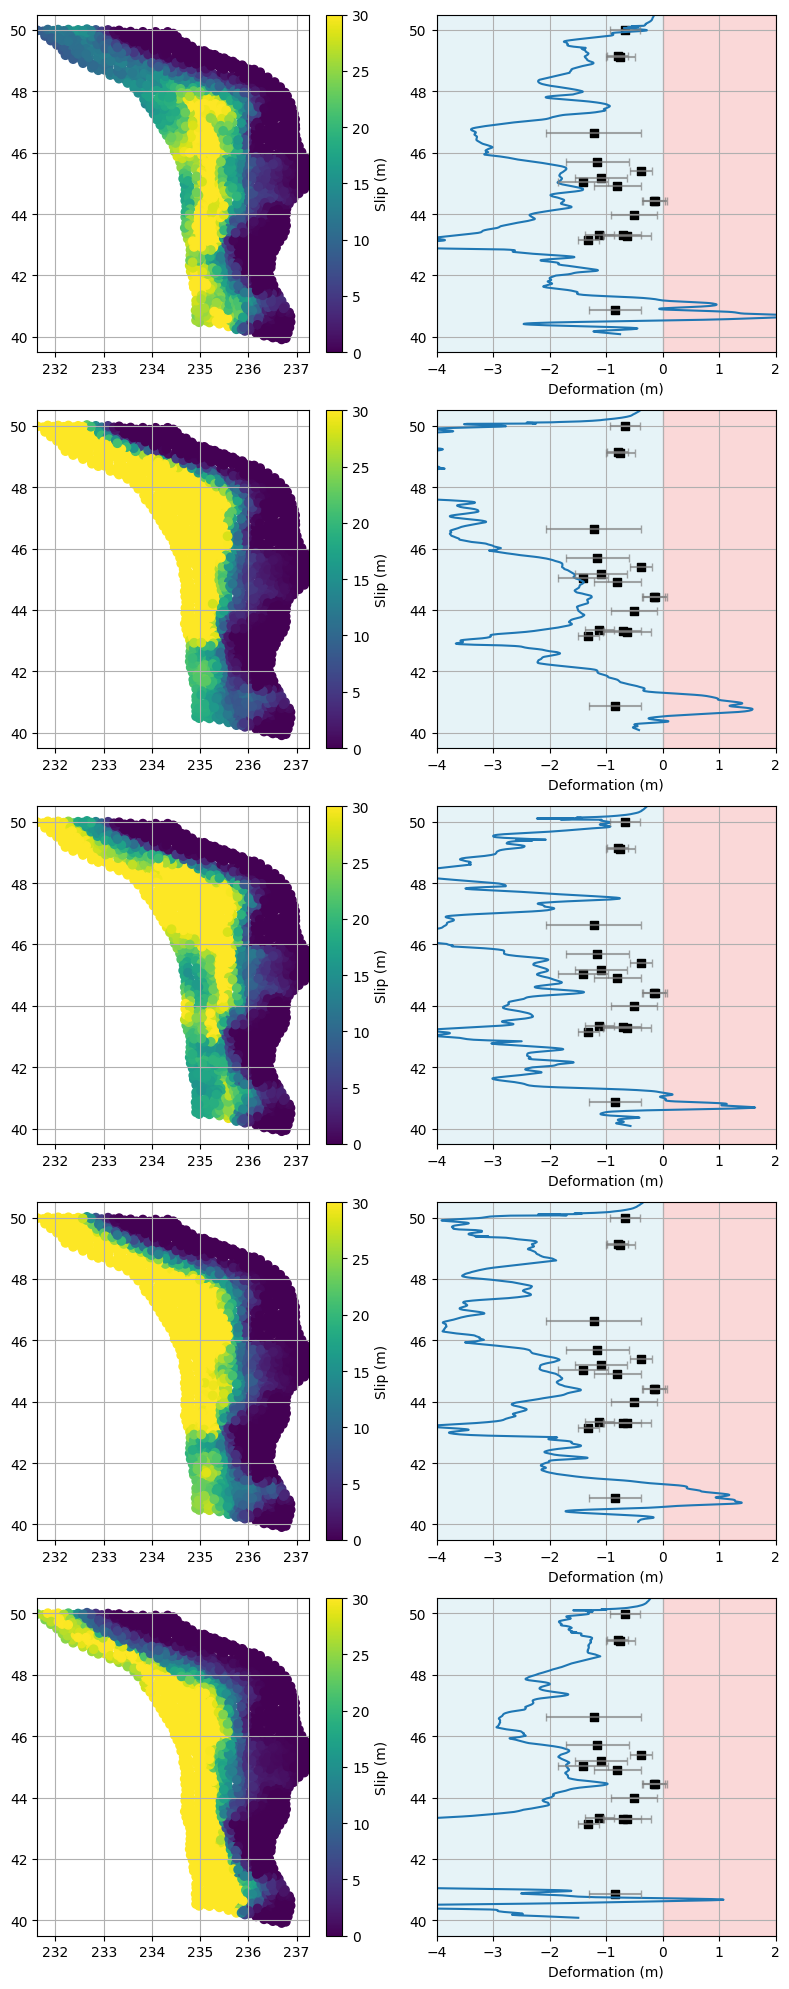

In [13]:
# Plot slip and deformation for each of the worst fitting models (2 panels per model, 10 panels total)
fig, axes = plt.subplots(5, 2, figsize=(8, 20))
axes = axes.flatten()

for idx, model_idx in enumerate(worst_fit_indices):
    # Load deformation data
    deformation_data = np.genfromtxt(all_deformation_models[model_idx])
    # Extract lat and deformation, then sort by lat
    model_lat = deformation_data[:, 2]
    model_deformation = deformation_data[:, 5]
    sort_idx = np.argsort(model_lat)
    model_lat = model_lat[sort_idx]
    model_deformation = model_deformation[sort_idx]
    
    # Find corresponding rupture file (assumes matching order)
    rupture_file = all_ruptures[model_idx]
    rupture_data = np.genfromtxt(rupture_file)
    rupture_lon = rupture_data[:, 1]
    rupture_lat = rupture_data[:, 2]
    rupture_slip = rupture_data[:, 9]
    
    # Plot slip
    ax1 = axes[2*idx]
    sc = ax1.scatter(rupture_lon, rupture_lat, c=rupture_slip, cmap='viridis', vmin=0, vmax=30)
    fig.colorbar(sc, ax=ax1, label='Slip (m)')
    ax1.set_xlim(rupture_lon.min(), rupture_lon.max())
    ax1.set_ylim(lat_lims)
    ax1.grid(which='both')

    # Plot deformation
    ax2 = axes[2*idx+1]
    ax2.plot(model_deformation, model_lat)
    ax2.scatter(paleo_deformation, paleo_lat, color='k', marker='s')
    ax2.errorbar(paleo_deformation, paleo_lat, xerr=paleo_uncertainty, fmt='none', ecolor='gray', alpha=0.7, capsize=3)
    ax2.set_xlim(-4, 2)
    ax2.set_ylim(lat_lims)
    ax2.set_xlabel('Deformation (m)')

    ax2.axvspan(deformation_lims[0], 0, color='lightblue', alpha=0.3, zorder=0)
    ax2.axvspan(0, deformation_lims[1], color='lightcoral', alpha=0.3, zorder=0)
    ax2.grid(which='both')

plt.tight_layout()
plt.show()

### What trends do we notice??? Discuss...

Now that we've visualized the five best-fitting and five worst-fitting models, take a close look at the plots for each group:

- **For the best-fitting models:**  
    - Do you notice any similarities in the slip distributions or deformation curves?
    - Are there particular latitudes where the models consistently match the paleo data well?
    - How do the predicted deformation patterns compare to the observed data and their uncertainties?

- **For the worst-fitting models:**  
    - What stands out about their slip distributions or deformation predictions?
    - Are there systematic mismatches at certain latitudes?
    - Do these models tend to overpredict or underpredict deformation in specific regions?

---

#### **Challenge:**  
Carefully examine the figures and try to identify any patterns or trends that distinguish the best-fitting models from the worst-fitting ones. Consider the following:

- Are there geographic regions where all good models perform well (or all bad models perform poorly)?
- Do the best-fitting models share common features in their slip distributions (e.g., high slip in certain segments)?
- Are the worst-fitting models characterized by unrealistic deformation patterns or outliers?
- Can you hypothesize why certain models fit the data better than others?

This exercise will help you develop an intuition for how model parameters and physical processes influence the fit to geological data!